## Import Libraries & Load Dataset

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Flatten , Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

Found 5216 files belonging to 2 classes.


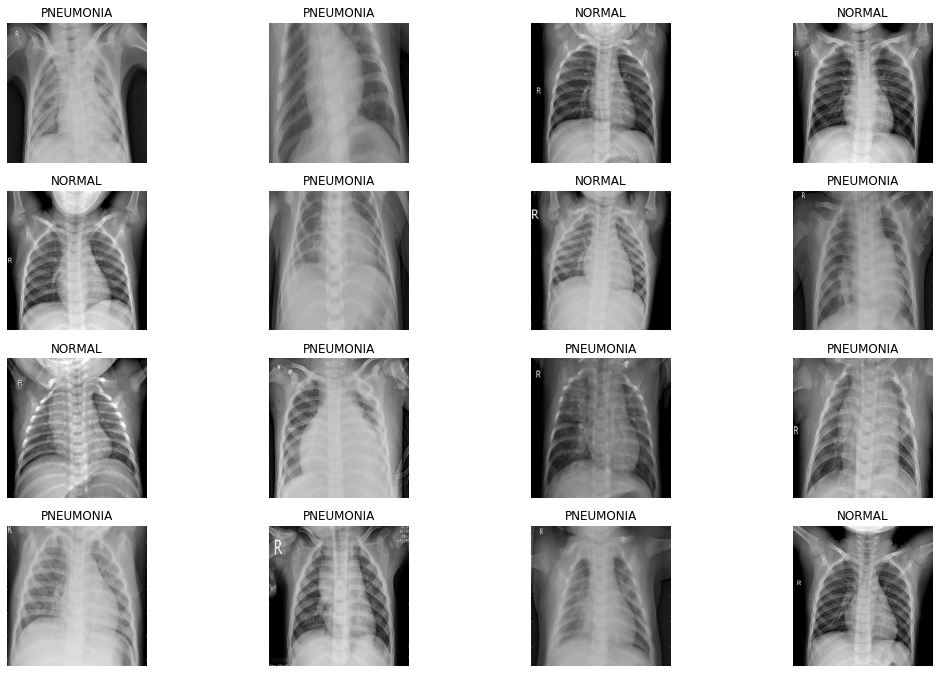

In [20]:
train_pic = image_dataset_from_directory("/content/drive/MyDrive/chest_xray/train",seed=7)
labels = train_pic.class_names
plt.figure(figsize=(18,18))
for img, label in train_pic.take(1):
  for i in range(16):
    ax = plt.subplot(6,4, i + 1)
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.title(labels[label[i]])
    plt.axis("off")

In [2]:
image_generator= ImageDataGenerator(
    rescale = 1.0/255.0,
    zoom_range = 0.2,
    shear_range = 0.2,
    horizontal_flip = True
)
image_generator_test = ImageDataGenerator(
    rescale = 1.0/255.0
)

In [3]:
train_images = image_generator.flow_from_directory(
    "/content/drive/MyDrive/chest_xray/train",
    class_mode = "binary",
    batch_size = 32,
    target_size = (224,224)
    )
test_images = image_generator_test.flow_from_directory(
    "/content/drive/MyDrive/chest_xray/test",
    class_mode = "binary",
    batch_size = 32,
    target_size = (224,224)
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Preprocessing

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Bar chart to visualize the X-Ray')

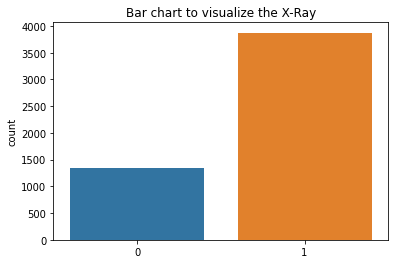

In [5]:
sns.countplot(train_images.classes)
plt.title("Bar chart to visualize the X-Ray")

## Balance

In [4]:
weight = compute_class_weight(class_weight="balanced",classes=np.unique(train_images.classes),y=train_images.classes)
class_weight = dict(zip(np.unique(train_images.classes),weight))

# Model

# Transfer Learning
## MobileNetV2

In [24]:
model_mobilenet = MobileNetV2(weights="imagenet",input_shape=(224,224,3),include_top=False)

In [25]:
model_mobilenet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [26]:
model_mobilenet.trainable = False
model = Sequential()
model.add(model_mobilenet)
model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(256,activation="relu"))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1,activation="sigmoid"))

In [27]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_3 (Flatten)         (None, 62720)             0         
                                                                 
 dense_12 (Dense)            (None, 1024)              64226304  
                                                                 
 dense_13 (Dense)            (None, 256)               262400    
                                                                 
 dense_14 (Dense)            (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                      

In [28]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss="binary_crossentropy",metrics=["accuracy"])
checkpoint_mobilenet = ModelCheckpoint("XRaymodel_mobilenet.h5",monitor="val_accuracy",mode="max",save_best_only=True)

In [29]:
history_mobilenet = model.fit_generator(train_images,
                              steps_per_epoch=len(train_images),
                              epochs=20,
                              validation_data=test_images,
                              validation_steps=len(test_images),
                              callbacks=[checkpoint_mobilenet],
                              class_weight=class_weight)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/20
163/163 [==============================] - 323s 2s/step - loss: 0.3000 - accuracy: 0.9068 - val_loss: 0.7719 - val_accuracy: 0.8205
Epoch 2/20
163/163 [==============================] - 314s 2s/step - loss: 0.1381 - accuracy: 0.9463 - val_loss: 0.2937 - val_accuracy: 0.8974
Epoch 3/20
163/163 [==============================] - 314s 2s/step - loss: 0.1432 - accuracy: 0.9479 - val_loss: 0.3267 - val_accuracy: 0.8750
Epoch 4/20
163/163 [==============================] - 319s 2s/step - loss: 0.1041 - accuracy: 0.9622 - val_loss: 0.2662 - val_accuracy: 0.9103
Epoch 5/20
163/163 [==============================] - 318s 2s/step - loss: 0.0939 - accuracy: 0.9620 - val_loss: 0.2003 - val_accuracy: 0.9103
Epoch 6/20
163/163 [==============================] - 317s 2s/step - loss: 0.0778 - accuracy: 0.9705 - val_loss: 0.2650 - val_accuracy: 0.9103
Epoch 7/20
163/163 [==============================] - 315s 2s/step - loss: 0.0827 - accuracy: 0.9678 - val_loss: 0.2511 - val_accuracy: 0.9103

In [30]:
print("Accuracy: ",max(history_mobilenet.history["val_accuracy"]))

Accuracy:  0.9182692170143127


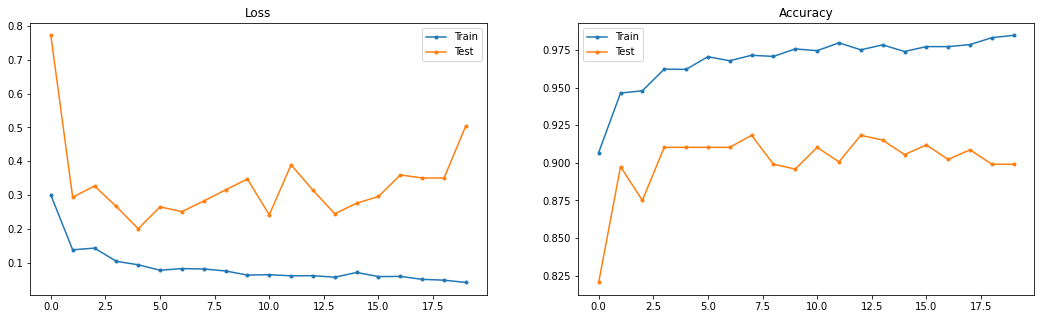

In [31]:
fig , (ax1,ax2) = plt.subplots(1,2,figsize=(18,5))
ax1.set_title("Loss")
ax2.set_title("Accuracy")
ax1.plot(history_mobilenet.history["loss"],label="Train",marker=".")
ax1.plot(history_mobilenet.history["val_loss"],label="Test",marker=".")
ax2.plot(history_mobilenet.history["accuracy"],label="Train",marker=".")
ax2.plot(history_mobilenet.history["val_accuracy"],label="Test",marker=".")
ax1.legend()
ax2.legend()
plt.show()

## InceptionV3

In [5]:
model_inception = InceptionV3(weights="imagenet",input_shape=(224,224,3),include_top=False)

87924736/87910968 [==============================] - 2s 0us/step


In [6]:
model_inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [7]:
model_inception.trainable = False
model = Sequential()
model.add(model_inception)
model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(256,activation="relu"))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1,activation="sigmoid"))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 1024)              52429824  
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1

In [8]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss="binary_crossentropy",metrics=["accuracy"])
checkpoint_inception = ModelCheckpoint("XRaymodel_inception.h5",monitor="val_accuracy",mode="max",save_best_only=True)

In [9]:
history_inception = model.fit_generator(train_images,
                              steps_per_epoch=len(train_images),
                              epochs=15,
                              validation_data=test_images,
                              validation_steps=len(test_images),
                              callbacks=[checkpoint_inception],
                              class_weight=class_weight)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/15
163/163 [==============================] - 1206s 7s/step - loss: 0.4001 - accuracy: 0.8623 - val_loss: 0.3597 - val_accuracy: 0.8670
Epoch 2/15
163/163 [==============================] - 682s 4s/step - loss: 0.2120 - accuracy: 0.9206 - val_loss: 0.3865 - val_accuracy: 0.8686
Epoch 3/15
163/163 [==============================] - 684s 4s/step - loss: 0.1815 - accuracy: 0.9333 - val_loss: 0.3496 - val_accuracy: 0.8750
Epoch 4/15
163/163 [==============================] - 693s 4s/step - loss: 0.1658 - accuracy: 0.9396 - val_loss: 0.3165 - val_accuracy: 0.8862
Epoch 5/15
163/163 [==============================] - 703s 4s/step - loss: 0.1610 - accuracy: 0.9387 - val_loss: 0.3445 - val_accuracy: 0.8670
Epoch 6/15
163/163 [==============================] - 704s 4s/step - loss: 0.1409 - accuracy: 0.9480 - val_loss: 0.3193 - val_accuracy: 0.9006
Epoch 7/15
163/163 [==============================] - 707s 4s/step - loss: 0.1418 - accuracy: 0.9454 - val_loss: 0.3310 - val_accuracy: 0.887

In [10]:
print("Accuracy: ",max(history_inception.history["val_accuracy"]))

Accuracy:  0.9086538553237915


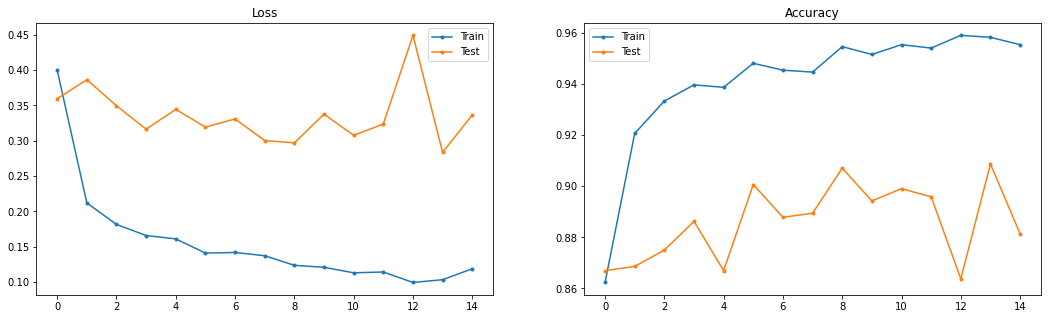

In [11]:
fig , (ax1,ax2) = plt.subplots(1,2,figsize=(18,5))
ax1.set_title("Loss")
ax2.set_title("Accuracy")
ax1.plot(history_inception.history["loss"],label="Train",marker=".")
ax1.plot(history_inception.history["val_loss"],label="Test",marker=".")
ax2.plot(history_inception.history["accuracy"],label="Train",marker=".")
ax2.plot(history_inception.history["val_accuracy"],label="Test",marker=".")
ax1.legend()
ax2.legend()
plt.show()

## Xception

In [5]:
model_xception = Xception(weights="imagenet",input_shape=(224,224,3),include_top=False)

In [6]:
model_xception.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [7]:
model_xception.trainable = False
model = Sequential()
model.add(model_xception)
model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(256,activation="relu"))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1,activation="sigmoid"))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 1024)              102761472 
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1

In [9]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss="binary_crossentropy",metrics=["accuracy"])
checkpoint_xception = ModelCheckpoint("XRaymodel_xception.h5",monitor="val_accuracy",mode="max",save_best_only=True)

In [10]:
history_xception = model.fit_generator(train_images,
                              steps_per_epoch=len(train_images),
                              epochs=10,
                              validation_data=test_images,
                              validation_steps=len(test_images),
                              callbacks=[checkpoint_xception],
                              class_weight=class_weight)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/10
163/163 [==============================] - 1246s 8s/step - loss: 0.3012 - accuracy: 0.8921 - val_loss: 0.2630 - val_accuracy: 0.8798
Epoch 2/10
163/163 [==============================] - 1237s 8s/step - loss: 0.1675 - accuracy: 0.9362 - val_loss: 0.3211 - val_accuracy: 0.8734
Epoch 3/10
163/163 [==============================] - 1243s 8s/step - loss: 0.1454 - accuracy: 0.9436 - val_loss: 0.2648 - val_accuracy: 0.9119
Epoch 4/10
163/163 [==============================] - 1249s 8s/step - loss: 0.1459 - accuracy: 0.9465 - val_loss: 0.2973 - val_accuracy: 0.8894
Epoch 5/10
163/163 [==============================] - 1241s 8s/step - loss: 0.1300 - accuracy: 0.9538 - val_loss: 0.3049 - val_accuracy: 0.8846
Epoch 6/10
163/163 [==============================] - 1240s 8s/step - loss: 0.1286 - accuracy: 0.9521 - val_loss: 0.2847 - val_accuracy: 0.8894
Epoch 7/10
163/163 [==============================] - 1246s 8s/step - loss: 0.1299 - accuracy: 0.9479 - val_loss: 0.2227 - val_accuracy:

In [11]:
print("Accuracy: ",max(history_xception.history["val_accuracy"]))

Accuracy:  0.9150640964508057


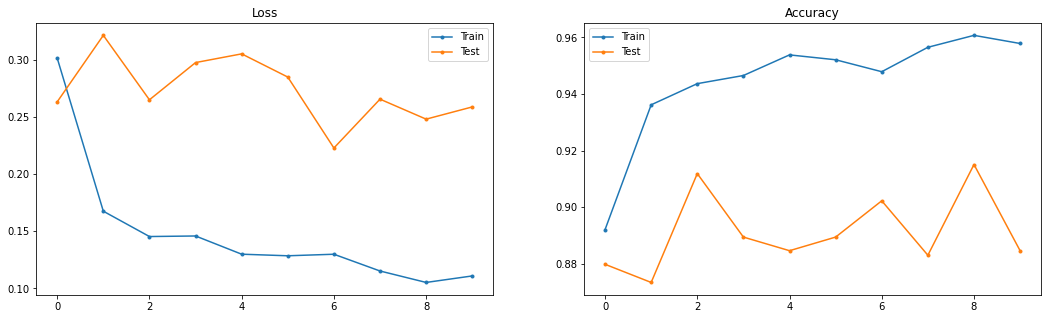

In [12]:
fig , (ax1,ax2) = plt.subplots(1,2,figsize=(18,5))
ax1.set_title("Loss")
ax2.set_title("Accuracy")
ax1.plot(history_xception.history["loss"],label="Train",marker=".")
ax1.plot(history_xception.history["val_loss"],label="Test",marker=".")
ax2.plot(history_xception.history["accuracy"],label="Train",marker=".")
ax2.plot(history_xception.history["val_accuracy"],label="Test",marker=".")
ax1.legend()
ax2.legend()
plt.show()